# Predicting Home Prices in Seattle with a Multilinear Regression Model

Please fill out:
* Student name: Ben Atkin
* Student pace: full time
* Scheduled project review date/time: 
* Instructor name: Abhineet Kulkarni
* Blog post URL:


The goal of this project is to clean, explore, and then model the King County, Washington dataset with a multivariate linear regression to predict the sale price of houses as accurately as possible.

# Setup notebook

In [1]:
# General python libraries
import json
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import pickle
import re

# Geo mapping libraries
from branca.colormap import linear
import geopandas as gpd
from shapely.geometry import Point, Polygon
from ipyleaflet import Map, GeoData, basemaps, LayersControl, Choropleth, Heatmap, FullScreenControl
from ipyleaflet import WidgetControl, GeoJSON 
from ipywidgets import Text, HTML
import geopandas

# Statistics and regression libraries
from scipy.stats import zscore
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import minmax_scale
import statsmodels.api as sm
import statsmodels.stats.api as sms


def create_geobins(df_lat_ser, 
                   df_long_ser, 
                   n_lats=10, 
                   n_longs=10, 
                   constrain_lat=None, 
                   constrain_long=None):
    """Create geodataframe using lats/longs to create the cells
    
    parameters:
        df_lat_ser: pd.Series() representing latitudes
        df_long_ser: pd.Series() representing longitudes
        n_lats: Number of latitudes to break area into
        n_longs: Number of longitudes to break area into
        constrain_lat: Tuple of (min_lat, max_lat) that constrains geography to create geobins from
        constrain_long: Tuple of (min_long, max_long) that constrains geography to create geobins from
    """
    polygons = []
    if constrain_lat:
        min_lat, max_lat = constrain_lat
    else:
        max_lat = df_lat_ser.max()
        min_lat = df_lat_ser.min()
    if constrain_long:
        min_long, max_long = constrain_long
    else:
        max_long = df_long_ser.max()
        min_long = df_long_ser.min()
    lat_step = abs((max_lat - min_lat)) / n_lats
    long_step = abs((max_long - min_long)) / n_longs
    for this_lat in np.arange(min_lat, max_lat, lat_step):
        for this_long in np.arange(min_long, max_long, long_step):
            polygons.append(Polygon([
                (this_long, this_lat),
                (this_long, this_lat + lat_step),
                (this_long + long_step, this_lat + lat_step),
                (this_long+long_step, this_lat),
                (this_long, this_lat)
            ]))

    return gpd.GeoDataFrame(polygons, columns=['geometry'])


def get_dataframes(regex='.*'):
    """Find all dataframes in global namespace
    
    Excludes stored Jupyter output.
    
    Returns dict with key: value as df_name: df
    """
    dataframe_dict = {}
    for k in globals().keys():
        if (isinstance(eval(k), pd.core.frame.DataFrame) 
            and not k.startswith('_') 
            and re.search(regex, k)):
            dataframe_dict[k] = eval(k)
    return dataframe_dict

def print_df_stats(df_dict,
                   head=True,
                   describe=True, 
                   value_counts=True):
    """Print .info(), .head(), .describe() for dataframes

    use get_dataframes() to get df_dict
    """
    for name, df in df_dict.items():
        print('=' * 100)
        print(name)
        print(df.info(), '\n')
        if head:
            print(df.head(), '\n')
        if describe:
            print(df.describe(include='all'), '\n\n')
        if value_counts:
            for col in df.columns:
                print(f'Value counts for {col}:')
                print(df[col].value_counts(), '\n')
                
def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.01, 
                       threshold_out = 0.05, 
                       verbose=True):
    """ Perform a forward-backward feature selection 
    based on p-value from statsmodels.api.OLS
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        initial_list - list of features to start with (column names of X)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions
    Returns: list of selected features 
    Always set threshold_in < threshold_out to avoid infinite looping.
    See https://en.wikipedia.org/wiki/Stepwise_regression for the details
    """
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.idxmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

# Import the data

Column Names and descriptions for Kings County Data Set
* **id** - unique identified for a house
* **dateDate** - house was sold
* **pricePrice** -  is prediction target
* **bedroomsNumber** -  of Bedrooms/House
* **bathroomsNumber** -  of bathrooms/bedrooms
* **sqft_livingsquare** -  footage of the home
* **sqft_lotsquare** -  footage of the lot
* **floorsTotal** -  floors (levels) in house
* **waterfront** - House which has a view to a waterfront
* **view** - Has been viewed
* **condition** - How good the condition is ( Overall )
* **grade** - overall grade given to the housing unit, based on King County grading system
* **sqft_above** - square footage of house apart from basement
* **sqft_basement** - square footage of the basement
* **yr_built** - Built Year
* **yr_renovated** - Year when house was renovated
* **zipcode** - zip
* **lat** - Latitude coordinate
* **long** - Longitude coordinate
* **sqft_living15** - The square footage of interior housing living space for the nearest 15 neighbors

* **sqft_lot15** - The square footage of the land lots of the nearest 15 neighbors

In [2]:
df = pd.read_csv('kc_house_data.csv')

# Investigating data

In [3]:
print_df_stats(get_dataframes('df'))

df
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
id               21597 non-null int64
date             21597 non-null object
price            21597 non-null float64
bedrooms         21597 non-null int64
bathrooms        21597 non-null float64
sqft_living      21597 non-null int64
sqft_lot         21597 non-null int64
floors           21597 non-null float64
waterfront       19221 non-null float64
view             21534 non-null float64
condition        21597 non-null int64
grade            21597 non-null int64
sqft_above       21597 non-null int64
sqft_basement    21597 non-null object
yr_built         21597 non-null int64
yr_renovated     17755 non-null float64
zipcode          21597 non-null int64
lat              21597 non-null float64
long             21597 non-null float64
sqft_living15    21597 non-null int64
sqft_lot15       21597 non-null int64
dtypes: float64(8), int64(11), object(2)
memory usage: 3.5+ MB
None 

  

scatter requires x column to be numeric -- col: date
scatter requires x column to be numeric -- col: sqft_basement


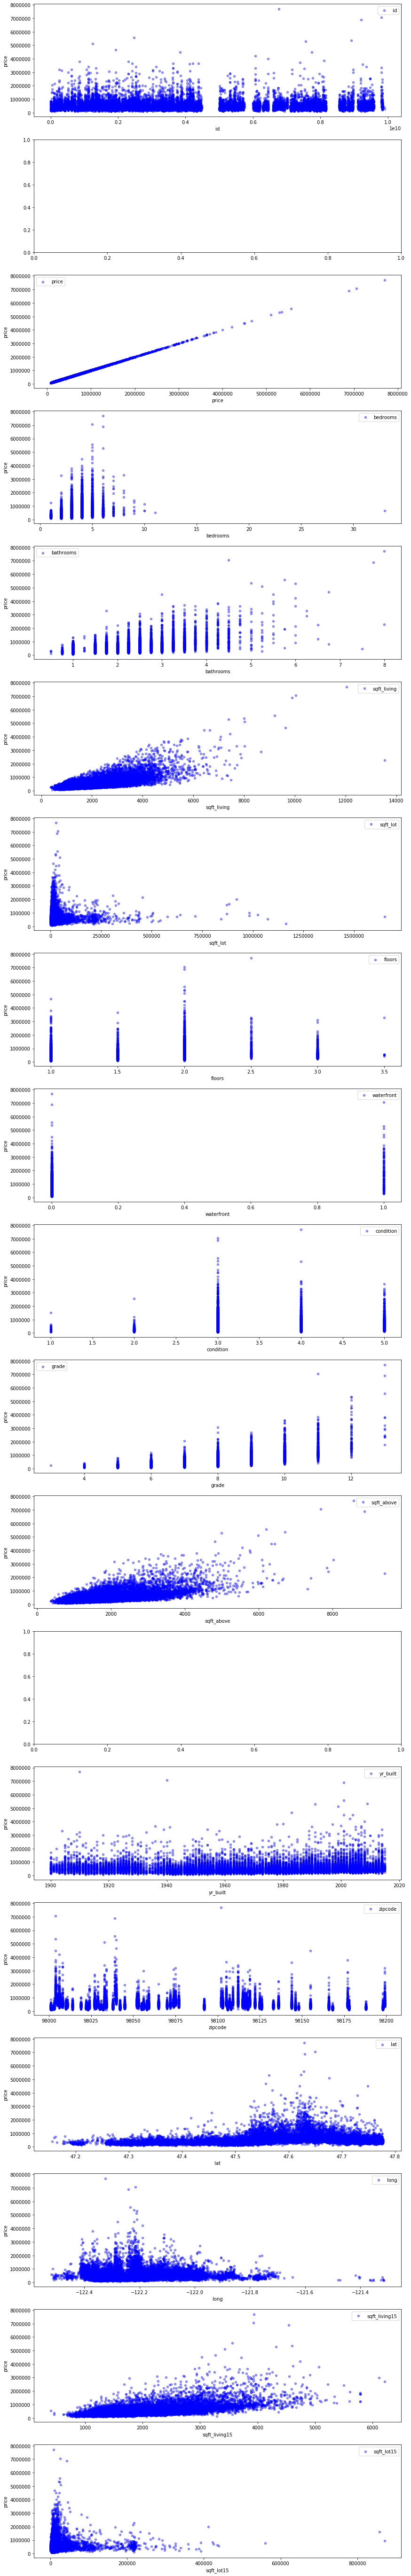

In [4]:
# Investigating which features are categorical, have outliers
cols = ['id', 
        'date', 
        'price', 
        'bedrooms', 
        'bathrooms', 
        'sqft_living',
        'sqft_lot', 
        'floors', 
        'waterfront', 
        'condition', 
        'grade', 
        'sqft_above',
        'sqft_basement', 
        'yr_built', 
        'zipcode', 
        'lat', 
        'long',
        'sqft_living15',
       'sqft_lot15'
       ]

fig, axes = plt.subplots(nrows=len(cols), ncols=1, figsize=(14,100))
for col, ax in zip(cols, axes):
    try:
        df.plot(kind='scatter', x=col, y='price', ax=ax, alpha=0.4, color='b', label=col)
    except ValueError as e:
        print(f'{e} -- col: {col}')
        pass

Looking at the graphs above, the following columns have outliers:

1. bedrooms,
2. bathrooms,
3. sqft_living,
4. sqft_lot,
5. sqft_above,
6. sqft_living15,
7. sqft_lot15

The following columns appear categorical:

1. condition
2. grade
3. zipcode

# Cleaning data

In [5]:
# Missing values
df.view.fillna(0, inplace=True)
df.yr_renovated.fillna(0, inplace=True)
df.waterfront.fillna(0, inplace=True)
sqft_basement_mean = df.sqft_basement.loc[df.sqft_basement != '?'].astype('float').mean()
df.sqft_basement.replace('?', sqft_basement_mean, inplace=True)

# Incorrect dtypes
df.date = pd.to_datetime(df.date)
df.price = df.price.astype('int64')
df.waterfront = df.waterfront.astype('int64')
df.sqft_basement = df.sqft_basement.astype('float').astype('int64')
df.view.astype('int64')

# Convert to binary column
df['has_basement'] = df.sqft_basement.map(lambda x: 1 if x > 0 else 0)
df['renovated'] = df.yr_renovated.map(lambda x: 1 if x > 0 else 0)

# Drop unused or already transformed columns
df.drop(['id', 'date', 'sqft_basement', 'yr_renovated'], axis=1, inplace=True);


# Remove outliers

In [6]:
outlier_cols = [
    'bedrooms',
    'bathrooms',
    'sqft_living',
    'sqft_lot',
    'sqft_above',
    'sqft_living15',
    'sqft_lot15'
]

for col in outlier_cols:
    df.drop(df.loc[zscore(df[col]) > 3].index, axis=0, inplace=True)

# Deal with categorical variables, including dealing with multicollinearity

Which features are categorical? From the above graphs in Investigating Data:
* condition
* grade
* zipcode

Features that I'll treat as categorical in a later iteration perhaps because they're arguably continuous.
* floors
* bedrooms
* bathrooms



In [7]:
# Change dtype of categorical columns, this was causing issues when inputting data to sm.OLS()
    # df.zipcode = df.zipcode.astype('category')
    # df.condition = df.condition.astype('category')
    # df.grade = df.grade.astype('category')

# Binning categorical variables
df.grade = pd.cut(df.grade, list(range(0, 16, 3)), labels=False)

# One-hot encoding other variables and dropping first column for dummy trap
df = pd.concat([df.drop('zipcode', axis=1), pd.get_dummies(df['zipcode'], drop_first=True)], axis=1)
    # df = pd.concat([df.drop('condition', axis=1), pd.get_dummies(df['condition'], drop_first=True)], axis=1)
    # df = pd.concat([df.drop('grade', axis=1), pd.get_dummies(df['grade'], drop_first=True)], axis=1)

# Get a baseline model with all features

In [8]:
y = df.price
X = df.iloc[:, 1:]
model = sm.OLS(y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.954
Model:                            OLS   Adj. R-squared (uncentered):              0.953
Method:                 Least Squares   F-statistic:                              4800.
Date:                Wed, 25 Mar 2020   Prob (F-statistic):                        0.00
Time:                        10:05:32   Log-Likelihood:                     -2.6549e+05
No. Observations:               20196   AIC:                                  5.311e+05
Df Residuals:                   20110   BIC:                                  5.318e+05
Df Model:                          86                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
bedrooms      -1.721e+04   1344.477    -12.803      0.000   -1.98e+04   -1.46e+04
bathrooms      1.923e+04   2218.509      8.668      0.000    1.49e+04    2.36e+04
sqft_living     106.8251      4.166     25.640      0.000      98.659     114.991
sqft_lot          1.1478      0.146      7.857      0.000       0.861       1.434
floors        -2.058e+04   2601.720     -7.911      0.000   -2.57e+04   -1.55e+04
waterfront      5.33e+05   1.36e+04     39.331      0.000    5.06e+05     5.6e+05
view           5.967e+04   1474.730     40.463      0.000    5.68e+04    6.26e+04
condition      2.835e+04   1532.662     18.500      0.000    2.54e+04    3.14e+04
grade          5.236e+04   2836.047     18.463      0.000    4.68e+04    5.79e+04
sqft_above       73.1312      4.531     16.140      0.000      64.250      82.012
yr_built       -214.6388     50.517     -4.249      0.000    -313.656    -115.622
lat            1.134e+04   4.83e+04      0.235      0.814   -8.34e+04    1.06e+05
long           3253.3485   1.87e+04      0.174      0.862   -3.34e+04    3.99e+04
sqft_living15    42.3786      2.533     16.728      0.000      37.413      47.344
sqft_lot15       -0.5439      0.218     -2.498      0.012      -0.971      -0.117
has_basement  -1372.8922   3257.743     -0.421      0.673   -7758.335    5012.550
renovated       4.85e+04   5154.807      9.408      0.000    3.84e+04    5.86e+04
98002          2.091e+04   1.11e+04      1.877      0.061    -928.971    4.28e+04
98003          3150.3771      1e+04      0.315      0.753   -1.65e+04    2.28e+04
98004          6.834e+05   1.91e+04     35.834      0.000    6.46e+05    7.21e+05
98005          3.367e+05   2.04e+04     16.498      0.000    2.97e+05    3.77e+05
98006          2.806e+05    1.7e+04     16.506      0.000    2.47e+05    3.14e+05
98007          2.671e+05   2.11e+04     12.650      0.000    2.26e+05    3.08e+05
98008          2.577e+05   2.03e+04     12.706      0.000    2.18e+05    2.97e+05
98010          8.209e+04   1.67e+04      4.909      0.000    4.93e+04    1.15e+05
98011          1.356e+05   2.55e+04      5.322      0.000    8.56e+04    1.86e+05
98014          1.166e+05   3.01e+04      3.874      0.000    5.76e+04    1.76e+05
98019          7.741e+04    2.9e+04      2.665      0.008    2.05e+04    1.34e+05
98022         -9392.1020   1.14e+04     -0.824      0.410   -3.17e+04    1.29e+04
98023         -1.125e+04   8853.764     -1.270      0.204   -2.86e+04    6105.706
98024          1.555e+05   2.81e+04      5.543      0.000    1.01e+05    2.11e+05
98027          2.003e+05   1.75e+04     11.424      0.000    1.66e+05    2.35e+05
98028          1.284e+05   2.42e+04      5.318      0.000    8.11e+04    1.76e+05
98029          2.372e+05   1.97e

The above model has an R-squared value of .954. Pretty good! This is just with a little bit of cleaning , removing outliers and one-hot encoding just the zipcode feature. Next, I'll log transform and scale the features to see if it improves the model.

# Log transform features

Which features need to be log transformed? Code below displays a histogram of the unchanged feature v.s. the log-transformed version to be able to quickly compare if a log-transformation will make the data appear more normally distributed.

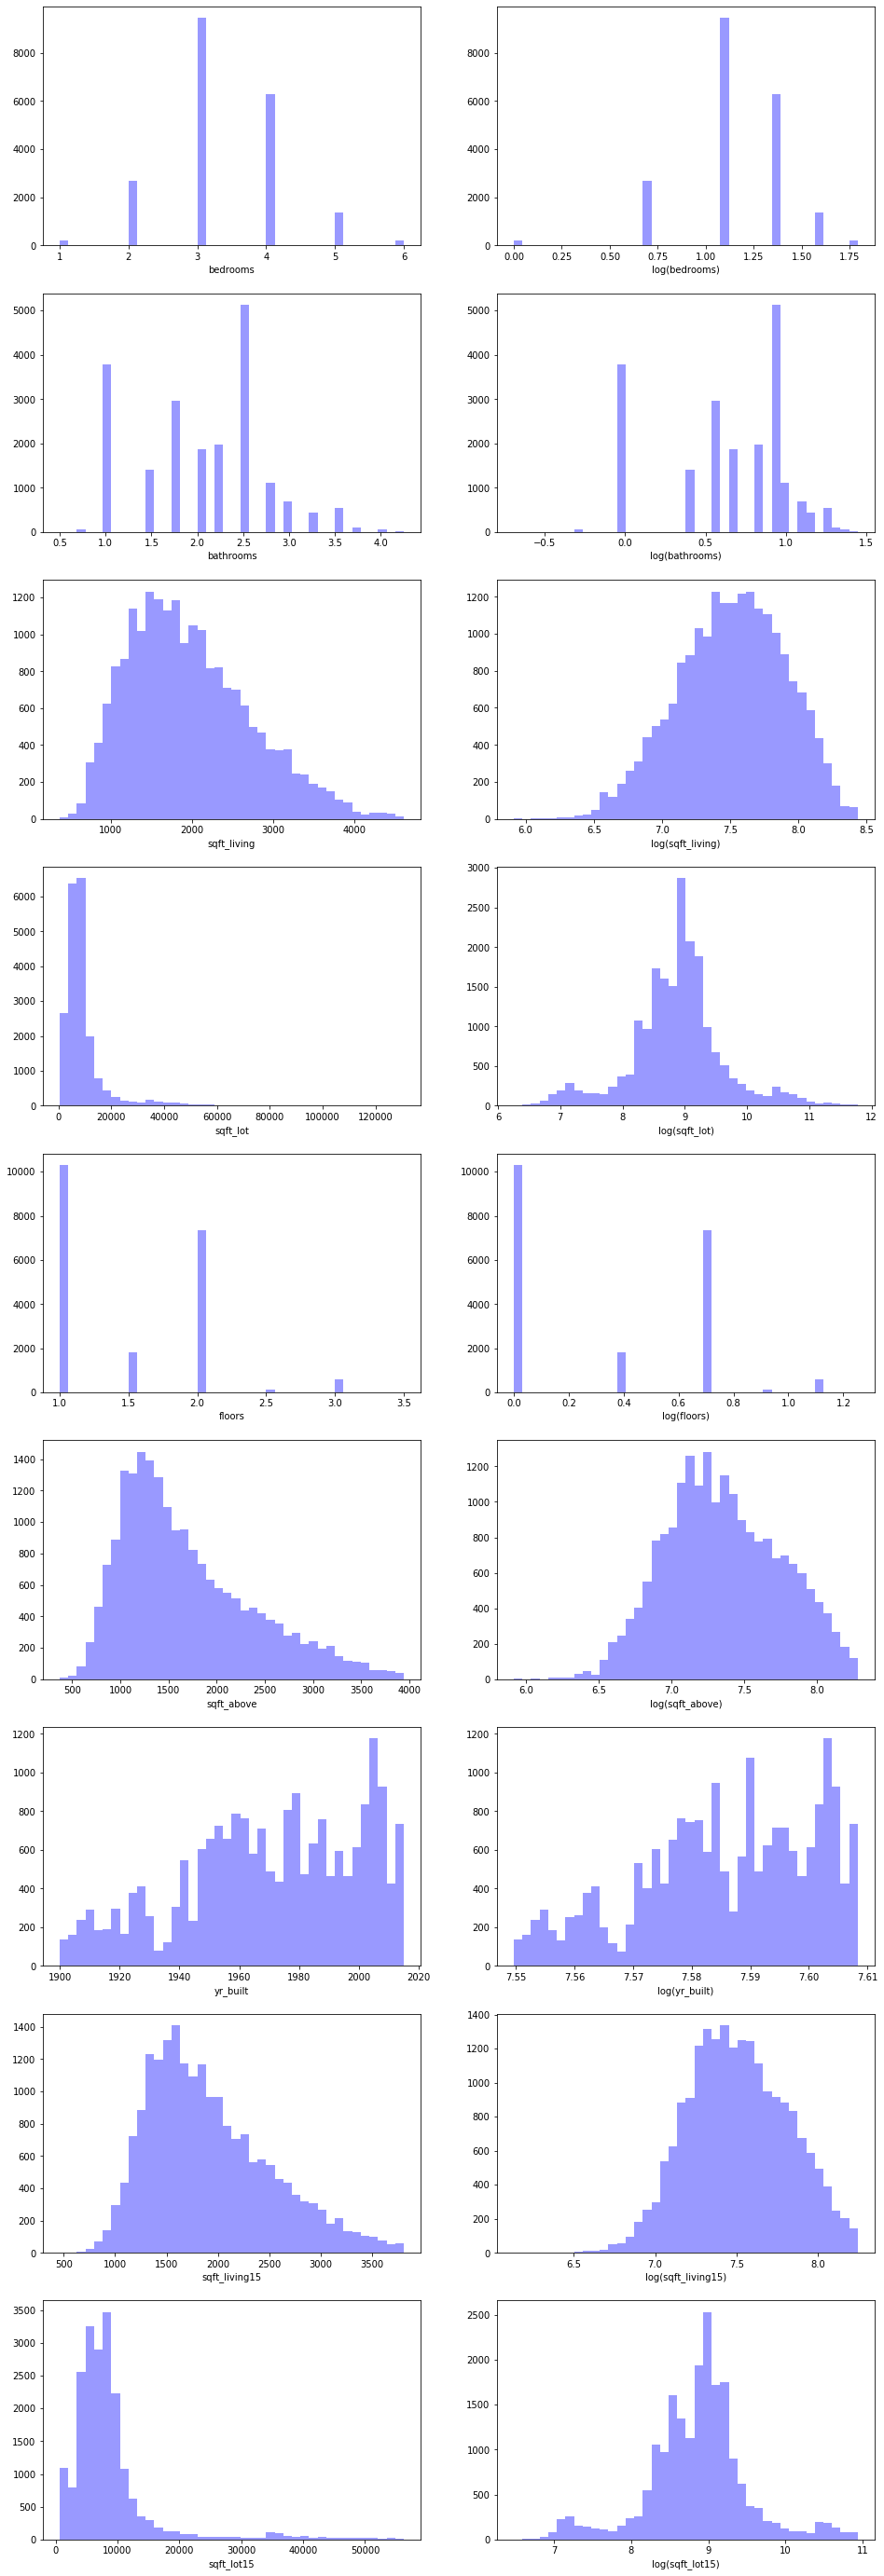

In [9]:
log_cols = [
    'bedrooms', 
    'bathrooms', 
    'sqft_living',
    'sqft_lot', 
    'floors',
    # 'waterfront', # Binary data, can't log zeroes and binary distribution isn't normal anyway
    # 'condition', # Categorical data doesn't make sense to log
    # 'grade', # Categorical data doesn't make sense to log
    'sqft_above',
    # 'sqft_basement', # Can't log because it has zero values
    'yr_built', 
    # 'zipcode', # Categorical data doesn't make sense to log
    # 'lat', # Not appropriate for lat
    # 'long', # Not appropriate for long, also can't log negative numbers
    'sqft_living15',
    'sqft_lot15'
       ]

fig, axes = plt.subplots(nrows=len(log_cols), ncols=2, figsize=(16, 50))
axes = list(axes.flatten())

for i, col in enumerate(log_cols):
    ax = axes.pop(0)
    log_ax = axes.pop(0)
    ax.set(xlabel=col)
    log_ax.set(xlabel=f'log({col})')
    ax.hist(df[col], bins=40, alpha=0.4, color='b', label=col)
    log_ax.hist(np.log(df[col]), bins=40, alpha=0.4, color='b', label=col)
plt.show()

The graphs show that many features would benefit from log-transforming them but some features (bedrooms, bathrooms, and floors) don't appear to be affected very much.

In [10]:
# Remove some features from the transform
log_cols.remove('bedrooms')
log_cols.remove('bathrooms')
log_cols.remove('floors')

# Log transform features
for col in log_cols:
    df[f'log_{col}'] = np.log(df[col])
    df.drop(col, axis=1, inplace=True)

# Scale features

Which features need to be scaled?

In [11]:
scale_cols = [
    # 'id', 
    # 'date', 
    # 'price', 
    'bedrooms', 
    'bathrooms', 
    'log_sqft_living',
    'log_sqft_lot', 
    'floors', 
    # 'waterfront', 
    # 'condition', 
    # 'grade', 
    'log_sqft_above',
    # 'yr_built', 
    # 'zipcode', 
    # 'lat', 
    # 'long',
    'log_sqft_living15',
    'log_sqft_lot15'
]

for col in scale_cols:
    df[f'scale_{col}'] = minmax_scale(df[col])
    df.drop(col, axis=1, inplace=True)

# Remove features that aren't statistically significant, stepwise feature selection

In [12]:
y = df.price
X = df.iloc[:, 1:]
result = stepwise_selection(X, y, verbose=True)

Add  scale_bathrooms                with p-value 0.0
Add  lat                            with p-value 0.0
Add  view                           with p-value 0.0
Add  grade                          with p-value 0.0
Add  scale_log_sqft_living15        with p-value 0.0
Add  log_yr_built                   with p-value 0.0
Add                           98004 with p-value 0.0
Add  scale_log_sqft_above           with p-value 2.87043e-259
Add                           98112 with p-value 4.10828e-197
Add                           98040 with p-value 2.63384e-206
Add  waterfront                     with p-value 2.69754e-154
Add                           98039 with p-value 7.08303e-131
Add  has_basement                   with p-value 3.93351e-104
Add                           98155 with p-value 3.49095e-88
Add                           98133 with p-value 2.41253e-85
Add                           98028 with p-value 2.33899e-97
Add                           98019 with p-value 3.88971e-78
Add          

The stepwise feature selection removed log_yr_built and 13 zip_codes. The feature scale_floors was initially dropped but then added back in at the end.

# Rerun model after all changes

In [13]:
y = df.price
X = df.iloc[:, 1:]
model = sm.OLS(y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.949
Model:                            OLS   Adj. R-squared (uncentered):              0.949
Method:                 Least Squares   F-statistic:                              4370.
Date:                Wed, 25 Mar 2020   Prob (F-statistic):                        0.00
Time:                        10:09:07   Log-Likelihood:                     -2.6639e+05
No. Observations:               20196   AIC:                                  5.329e+05
Df Residuals:                   20110   BIC:                                  5.336e+05
Df Model:                          86                                                  
Covariance Type:            nonrobust                                                  
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
waterfront                5.28e+05   1.42e+04     37.262      0.000       5e+05    5.56e+05
view                     6.443e+04   1523.815     42.285      0.000    6.14e+04    6.74e+04
condition                2.692e+04   1601.530     16.812      0.000    2.38e+04    3.01e+04
grade                    5.144e+04   3000.590     17.143      0.000    4.56e+04    5.73e+04
lat                      2.197e+04   5.07e+04      0.433      0.665   -7.74e+04    1.21e+05
long                     1700.9047   2.01e+04      0.084      0.933   -3.78e+04    4.12e+04
has_basement             2.493e+04   3689.415      6.757      0.000    1.77e+04    3.22e+04
renovated                4.914e+04   5387.031      9.122      0.000    3.86e+04    5.97e+04
98002                    3.373e+04   1.17e+04      2.891      0.004    1.09e+04    5.66e+04
98003                    4229.8136   1.05e+04      0.404      0.686   -1.63e+04    2.47e+04
98004                    7.054e+05      2e+04     35.297      0.000    6.66e+05    7.45e+05
98005                    3.484e+05   2.14e+04     16.310      0.000    3.07e+05     3.9e+05
98006                    3.031e+05   1.78e+04     17.053      0.000    2.68e+05    3.38e+05
98007                    2.777e+05   2.21e+04     12.567      0.000    2.34e+05    3.21e+05
98008                    2.653e+05   2.12e+04     12.498      0.000    2.24e+05    3.07e+05
98010                    8.518e+04   1.75e+04      4.859      0.000    5.08e+04     1.2e+05
98011                    1.404e+05   2.67e+04      5.260      0.000    8.81e+04    1.93e+05
98014                    1.156e+05   3.15e+04      3.673      0.000    5.39e+04    1.77e+05
98019                    7.484e+04   3.04e+04      2.464      0.014    1.53e+04    1.34e+05
98022                   -8827.1709    1.2e+04     -0.733      0.464   -3.24e+04    1.48e+04
98023                   -3314.1997   9272.312     -0.357      0.721   -2.15e+04    1.49e+04
98024                    1.495e+05   2.93e+04      5.100      0.000    9.21e+04    2.07e+05
98027                    2.164e+05   1.83e+04     11.796      0.000     1.8e+05    2.52e+05
98028                    1.322e+05   2.53e+04      5.221      0.000    8.26e+04    1.82e+05
98029                    2.511e+05   2.06e+04     12.197      0.000    2.11e+05    2.91e+05
98030                    6207.2049   1.17e+04      0.532      0.595   -1.66e+04    2.91e+04
98031                    1.253e+04   1.23e+04      1.019      0.308   -1.16e+04    3.66e+04
98032                    2.075e+04   1.39e+04      1.490      0.136   -6551.084    4.81e+04
98033                    3.757e+05   2.26e+04     16.645      0.000    3.31e+05     4.2e+05
98034                    2.042e+05   2.3

Interestingly, the model has an R-squared that is LOWER after the log transforming, scaling of features, and stepwise feature selection.

# Validate the model with k-fold cross validation

In [14]:
linreg = LinearRegression()
cv_10_results = np.mean(cross_val_score(linreg, X, y, cv=10, scoring='neg_mean_squared_error'))
cv_10_results

-17067436372.018192

# Pickle the model for portability

In [15]:
with open('regression_model.pickle', 'wb') as f:
    pickle.dump(model, f)

# Mapping the effect of zipcodes on price

A property's location, encoded by zipcode, is the most important feature in the dataset and you can see this by viewing the sorted list of coefficients in the model. 

It's difficult in linear regression to directly compare categorical and continuous features to determine which one has the "greatest effect". However, almost all the zipcodes (having a binomial distribution consisting of only 0's or 1's) have greater coefficients that the other categorical features which can take on much larger values. In addition, because I chose to use the minmax_scale function from sklearn I know any continuous features that I scaled will take on values less than 1. This way I can know that if a zipcode's coefficient is larger than a continuous variable's coefficient, than being located in that zipcode is more impactful on price than even the most extreme value in the continuous variable.

All in all, because of the way the data has been scaled and transformed, this sorted list of coefficients does a good job of estimating which features are most impactful on price. The following output shows the coefficients sorted with most impactful first.

In [16]:
model.params.sort_values(ascending=False).head(100)

98039                      997054.010238
98004                      705368.138709
98112                      660077.756807
98109                      564300.154769
98119                      542471.915344
98102                      540901.335377
98040                      536172.928389
waterfront                 527970.540236
98105                      511792.484499
98199                      460089.384997
scale_log_sqft_above       455354.267379
98122                      407824.384195
98103                      391443.253684
98107                      390558.721202
98115                      381552.502484
98117                      376516.787995
98033                      375697.830383
98116                      352245.887487
98005                      348413.958856
98144                      325869.615128
98006                      303101.560719
98136                      298788.752977
98007                      277687.630156
98052                      268712.935253
98008           

Given that location is so important, I want to see the zipcodes on a map and visually get a feeling for which areas around Seattle are most impactful on price. Here's a map that plots the zipcodes and corresponding coefficients from the final model.

In [17]:
def map_1():
    map_1_df = df
    map_1_model = model
    # Ingest shape file for King County zip codes
    gdf = geopandas.read_file('./Zipcodes_for_King_County_and_Surrounding_Area__zipcode_area')

    # Change zipcode to type int64
    gdf.ZIPCODE = gdf.ZIPCODE.astype('int64')

    # Process data for choropleth
    # Only plot where the zip code has a coef from model
    map_df_zips = set([k for k in model.params.index if re.search('\d{4}', str(k))])
    plot_zips = gdf.loc[gdf.ZIPCODE.map(lambda x: x in map_df_zips)]
    plot_zips.set_index('ZIPCODE', inplace=True)
    geojson_data = json.loads(plot_zips.to_json())
    model_coef_data = {str(k): v for k, v in model.params.to_dict().items()}

    # Colormap spec
    colormap = linear.Reds_06.scale(-25214, 966723)

    # Create layer
    choro_layer_coef = Choropleth(
        geo_data=geojson_data,
        choro_data=model_coef_data,
        colormap=colormap,
        border_color='black',
        style={'fillOpacity': 0.5}
    )

    # Create basemap, add choro_layer_coef
    m = Map(center=(47.5391,-122.070), zoom=9)
    m.add_layer(choro_layer_coef)

    # Create html widget
    html = HTML('''Hover over a zip_code''')
    html.layout.margin = '0px 20px 20px 20px'
    control = WidgetControl(widget=html, position='topright')
    m.add_control(control)

    # Function to handle hover event
    def update_html(feature,  **kwargs):
        zipcode = int(feature['id'])
        html.value = f'''
        Zipcode: {zipcode}<br>
        Model Coefficient: {round(map_1_model.params.loc[zipcode], 3)}<br>
        N samples: {map_1_df[zipcode].value_counts()[1]}
        '''
    # Set on hover event listener
    choro_layer_coef.on_hover(update_html)

    # display map
    return m
map_1()

Map(center=[47.5391, -122.07], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zo…

# Mapping lat/long groups in Seattle area and checking effect

## How should I define the Seattle area to include the majority of my sample data?

The zipcode map is helpful, but zipcodes are of an arbitrary size and shape. They're also generally too big to be meaningful when we think of a home's location. Smaller location geometries that affect homes prices like, school district, city blocks, or even just latitude/longitude blocks etc. would be better.

So what we'll do is split the data into many smaller "geobins". These polygons are much smaller than the zipcode data that was provided and will allow us to differentiate between different locations' affect on price more accurately. There is a danger here though. Because these geobins will be much smaller than zipcodes, we could potentially have geobins with low numbers of samples in them which would make that particular geobin's coefficient extremely sensitive to outliers. To combat this, we'll look for a small area that is densely populated with samples to run our analysis. Let's plot a heatmap to visualize the geographic distribution of our sample data.

In [18]:
def map_2():
    map_2_df = df
    # Create basemap
    m = Map(center=(47.5391,-122.070), zoom=9)

    # Create GeoDataFrame from map_2_df with points for geometry column
    gdf = geopandas.GeoDataFrame(
        map_2_df, geometry=geopandas.points_from_xy(map_2_df.long, map_2_df.lat))

    # Create geobins layer
    geobins = create_geobins(map_2_df.lat, 
                             map_2_df.long, 
                             n_lats=14, 
                             n_longs=20, 
                             constrain_lat=(47.5,47.73),
                             constrain_long=(-122.437, -122.138),
                            )

    geobins_layer = GeoData(geo_dataframe=geobins,
                           style={'color': 'black', 'weight':.1},
                           hover_style={'fillColor': 'red' , 'fillOpacity': 0.2},
                           name = 'geobins')


    # Create heatmap layer
    coords = list(zip(map_2_df.lat.values, map_2_df.long.values))

    heatmap = Heatmap(
        locations=coords,
        radius=10,
        min_opacity=.2,
        name='heatmap_of_observations'
    )


    # Add layers
    m.add_layer(geobins_layer)
    m.add_layer(heatmap)

    # Add controls
    m.add_control(LayersControl())

    # Display map
    return m
map_2()

Map(center=[47.5391, -122.07], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zo…

Using a heatmap to visualize the distribution of observations in our dataset, I've decided to run a regression analysis on the Seattle area (shown within the geobins grid). This includes the majority of my data and will allow me to be more granular while investigating what effect location has on home prices.

First, we need to encode the data for membership in one of our geobins, remove the zipcode data, and rerun the model!

In [19]:
map_3_gdf = geopandas.GeoDataFrame(
    df, geometry=geopandas.points_from_xy(df.long, df.lat))

# Create geobins layer
geobins = create_geobins(df.lat, 
                         df.long, 
                         n_lats=14, 
                         n_longs=20, 
                         constrain_lat=(47.5,47.73),
                         constrain_long=(-122.437, -122.138),
                        )

# One-hot encode the geometry column for membership in a geobin
for i, geobin in zip(geobins.index, geobins.geometry):
        map_3_gdf[f'geobin_{i}'] = map_3_gdf.geometry.within(geobin).map(lambda x: 1 if x else 0)

In [20]:
# Drop features that have no observations
has_any = map_3_gdf.any()
drop_cols = [column for column in map_3_gdf if has_any[column] == False]
map_3_gdf.drop(labels=drop_cols, axis=1, inplace=True)

# Remove all the zipcode features in lieu of the geobins
map_3_gdf.drop(labels=[k for k in map_3_gdf.columns if re.search('\d{4}', str(k))], axis=1, inplace=True)

# Drop geometry column because can't put it in model
map_3_gdf.drop(labels='geometry', axis=1, inplace=True)

In [21]:
y = map_3_gdf.price
X = map_3_gdf.iloc[:, 1:]
map_3_model = sm.OLS(y, X).fit()
map_3_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.952
Model:                            OLS   Adj. R-squared (uncentered):              0.951
Method:                 Least Squares   F-statistic:                              1626.
Date:                Wed, 25 Mar 2020   Prob (F-statistic):                        0.00
Time:                        10:09:49   Log-Likelihood:                     -2.6591e+05
No. Observations:               20196   AIC:                                  5.323e+05
Df Residuals:                   19955   BIC:                                  5.342e+05
Df Model:                         241                                                  
Covariance Type:            nonrobust                                                  
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
waterfront               5.638e+05   1.41e+04     39.939      0.000    5.36e+05    5.91e+05
view                     5.847e+04   1544.038     37.867      0.000    5.54e+04    6.15e+04
condition                2.528e+04   1537.798     16.439      0.000    2.23e+04    2.83e+04
grade                    5.693e+04   2916.259     19.522      0.000    5.12e+04    6.26e+04
lat                      4.578e+05   7217.237     63.437      0.000    4.44e+05    4.72e+05
long                     1.749e+05   5286.815     33.075      0.000    1.65e+05    1.85e+05
has_basement             2.264e+04   3630.605      6.237      0.000    1.55e+04    2.98e+04
renovated                4.345e+04   5250.787      8.275      0.000    3.32e+04    5.37e+04
log_yr_built            -1.069e+05    8.1e+04     -1.321      0.187   -2.66e+05    5.18e+04
scale_bedrooms          -6.267e+04   7068.620     -8.866      0.000   -7.65e+04   -4.88e+04
scale_bathrooms          1.147e+05   8536.089     13.438      0.000     9.8e+04    1.31e+05
scale_log_sqft_living    2.213e+05   2.25e+04      9.849      0.000    1.77e+05    2.65e+05
scale_log_sqft_lot       2.022e+05    1.7e+04     11.882      0.000    1.69e+05    2.36e+05
scale_floors            -3.234e+04   7038.621     -4.595      0.000   -4.61e+04   -1.85e+04
scale_log_sqft_above     4.275e+05   2.05e+04     20.852      0.000    3.87e+05    4.68e+05
scale_log_sqft_living15  1.596e+05   1.04e+04     15.406      0.000    1.39e+05     1.8e+05
scale_log_sqft_lot15    -3.387e+04   1.52e+04     -2.229      0.026   -6.37e+04   -4082.231
geobin_2                 1.647e+05   7.36e+04      2.237      0.025    2.04e+04    3.09e+05
geobin_3                 1.548e+05   1.72e+04      8.992      0.000    1.21e+05    1.89e+05
geobin_4                 1.204e+05   1.67e+04      7.206      0.000    8.77e+04    1.53e+05
geobin_5                 9.139e+04    1.7e+04      5.361      0.000     5.8e+04    1.25e+05
geobin_6                 4.864e+04   1.93e+04      2.517      0.012    1.08e+04    8.65e+04
geobin_7                 4.565e+04    2.3e+04      1.987      0.047     617.060    9.07e+04
geobin_8                -3.945e+04   3.54e+04     -1.116      0.264   -1.09e+05    2.98e+04
geobin_9                 3.274e+04   4.82e+04      0.680      0.497   -6.16e+04    1.27e+05
geobin_10               -8.244e+04   7.35e+04     -1.122      0.262   -2.26e+05    6.16e+04
geobin_11                6530.0533   1.79e+04      0.364      0.716   -2.86e+04    4.17e+04
geobin_12               -2.903e+04   1.69e+04     -1.719      0.086   -6.21e+04    4067.789
geobin_13               -7.271e+04    2.2e+04     -3.307      0.001   -1.16e+05   -2.96e+04
geobin_14                 -2.4e+05   4.8

Now we're ready to create the map. (Note: Holes in the map mean that there was no sample data available in that geobin.)

In [22]:
def map_3():    
    # Process data for choropleth
    # Only plot where the geobin has a coef from model
    model_coef_data = {k.split('_')[1]: v 
                       for k, v in map_3_model.params.to_dict().items() 
                       if k.startswith('geobin_')}
    geobins_to_plot = geobins.iloc[list(model_coef_data.keys())]
    geojson_data = json.loads(geobins_to_plot.to_json())


    # Colormap spec
    colormap = linear.Reds_06.scale(-1145939, 1159950)

    # Create layer
    choro_layer_geobins_coef = Choropleth(
        geo_data=geojson_data,
        choro_data=model_coef_data,
        colormap=colormap,
        border_color='black',
        style={'fillOpacity': 0.5},
        name='Geobins Choropleth'
    )

    # Create basemap, add choro_layer_coef
    m = Map(center=(47.6,-122.25), zoom=11, basemap=basemaps.OpenStreetMap.BlackAndWhite)
    m.add_layer(choro_layer_geobins_coef)

    # Create html widget
    html = HTML('''Hover over a zip_code''')
    html.layout.margin = '0px 20px 20px 20px'
    control = WidgetControl(widget=html, position='topright')
    m.add_control(control)

    # Function to handle hover event
    def update_html(feature,  **kwargs):
        id = feature['id']
        geobin_col = f'geobin_{id}'
        html.value = f'''
        Model Coefficient: {round(model_coef_data[id], 3)}<br>
        N samples: {map_3_gdf[geobin_col].sum()}
        '''
    # Set on hover event listener
    choro_layer_geobins_coef.on_hover(update_html)

    # Add controls
    m.add_control(LayersControl())
    m.add_control(FullScreenControl())
    
    # display map
    return m
map_3()

Map(center=[47.6, -122.25], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_…

The geobins layer map shows that price and location are correlated in some interesting ways. We can see that homes that are closer to Seattle city center are significantly more expensive and that waterfront homes also carry a premium. It also points out a few communities that are very pricey as well, for example, the Broadmoor Golf Community in the center of Seattle. More granular versions of the model could be used to find even more interesting patterns like this.